In [1]:
# =========================================================
# 1. Imports
# =========================================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

In [2]:
# =========================================================
# 2. Load dataset
# =========================================================
df = pd.read_csv("data/online_shoppers_intention.csv")
print("Dataset loaded:", df.shape)

Dataset loaded: (12330, 18)


In [3]:
# =========================================================
# 3. Convert boolean variables to numeric
# =========================================================
df['Revenue'] = df['Revenue'].astype(int)
df['Weekend'] = df['Weekend'].astype(int)


# =========================================================
# 4. Group rare categories in numeric-categorical features
# =========================================================
numeric_categorical = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

def group_rare(series, threshold=50):
    freq = series.value_counts()
    return series.apply(lambda x: x if freq[x] > threshold else "Other")

for col in numeric_categorical:
    df[col] = df[col].astype(str)          # Convert to string for grouping + encoding
    df[col] = group_rare(df[col])


# =========================================================
# 5. One-hot encode *all* categorical variables
# =========================================================
categorical_nominal = ['Month', 'VisitorType'] + numeric_categorical

df = pd.get_dummies(df, columns=categorical_nominal, drop_first=True)
print("After encoding:", df.shape)


# =========================================================
# 6. Log-transform skewed duration features
# =========================================================
duration_cols = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration'
]

for col in duration_cols:
    df[col] = np.log1p(df[col])


After encoding: (12330, 56)


In [4]:
# =========================================================
# 7. Train / Test Split (stratified)
# =========================================================
X = df.drop('Revenue', axis=1)
y = df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (9864, 55)  Test: (2466, 55)


In [5]:

# =========================================================
# 8. Scale numerical features (no leakage)
# =========================================================
numerical_features = X_train.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encounter

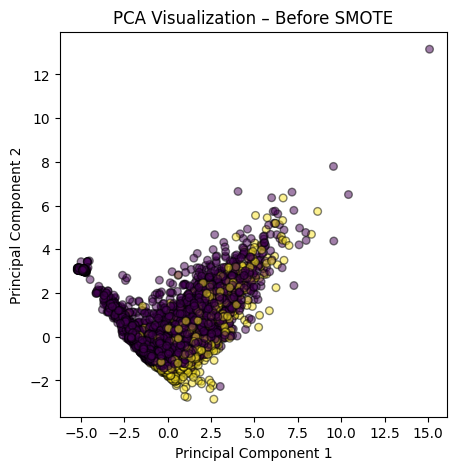

In [6]:
# =========================================================
# 9. PCA (for visualization only, not for training)
# =========================================================
pca = PCA(n_components=2)
pca.fit(X_train_scaled)  # Fit only on training set

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# Plotting helper
def plot_data(X, y, ax, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s=30, edgecolor=(0,0,0,0.5))
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(title)


fig, ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_pca, y_train, ax, title='PCA Visualization – Before SMOTE')

/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/tania_priv/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.

After SMOTE: (16676, 55)


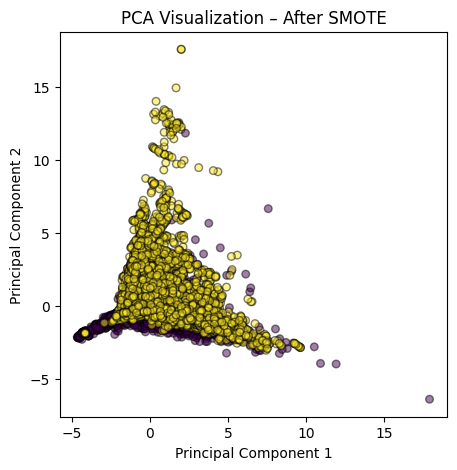

In [7]:
# =========================================================
# 10. SMOTE on the scaled data (NOT PCA)
# =========================================================
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

fig, ax = plt.subplots(figsize=(5, 5))
plot_data(
    PCA(n_components=2).fit_transform(X_train_smote),
    y_train_smote,
    ax,
    title='PCA Visualization – After SMOTE'
)

print("After SMOTE:", X_train_smote.shape)